<a href="https://colab.research.google.com/github/17092003vamsi/HUNTERs/blob/main/HUNTER_2026_cnnc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5377 - auc: 0.5336 - loss: 0.8531 - val_accuracy: 0.7374 - val_auc: 0.7582 - val_loss: 0.6642
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7150 - auc: 0.6972 - loss: 0.6271 - val_accuracy: 0.5960 - val_auc: 0.7256 - val_loss: 0.6884
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7177 - auc: 0.6339 - loss: 0.6523 - val_accuracy: 0.3636 - val_auc: 0.7297 - val_loss: 0.7051
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6773 - auc: 0.6097 - loss: 0.6439 - val_accuracy: 0.3030 - val_auc: 0.7184 - val_loss: 0.7277
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6806 - auc: 0.6135 - loss: 0.6284 - val_accuracy: 0.3232 - val_auc: 0.7292 - val_loss: 0.7356
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7340 - auc: 0.6480 - loss: 0.5993 - val_accuracy: 0.3232 - val_auc: 0.7307 - val_loss: 0.7492
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy

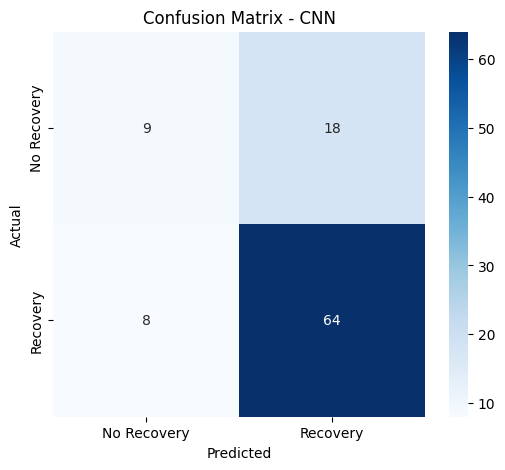

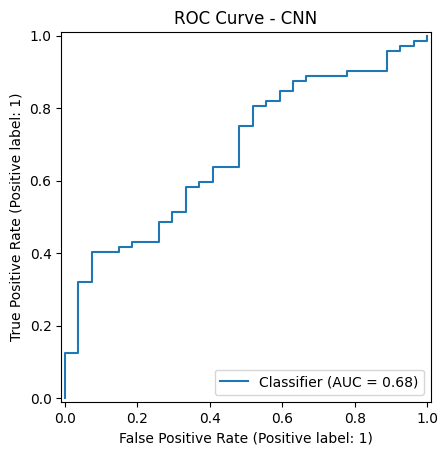


🔎 Running LIME explainability on CNN...
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ LIME explanation for patient 0:


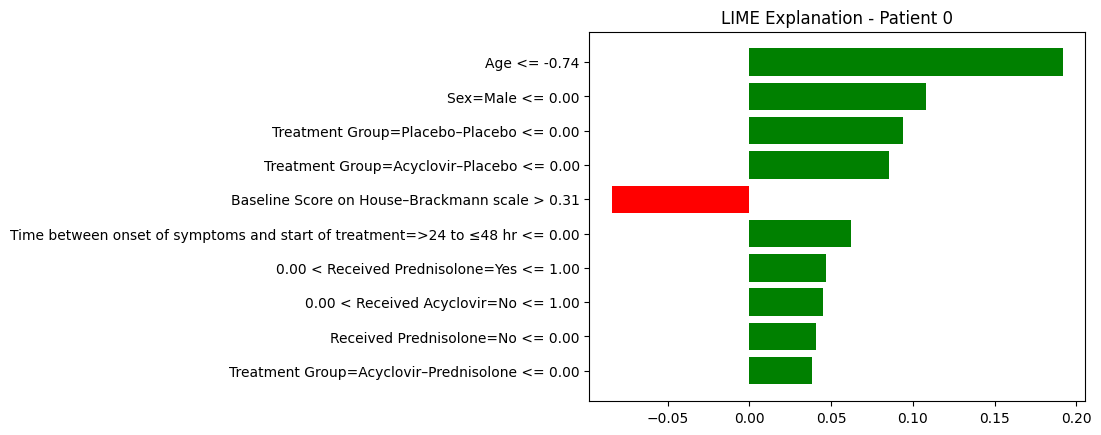

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ LIME explanation for patient 1:


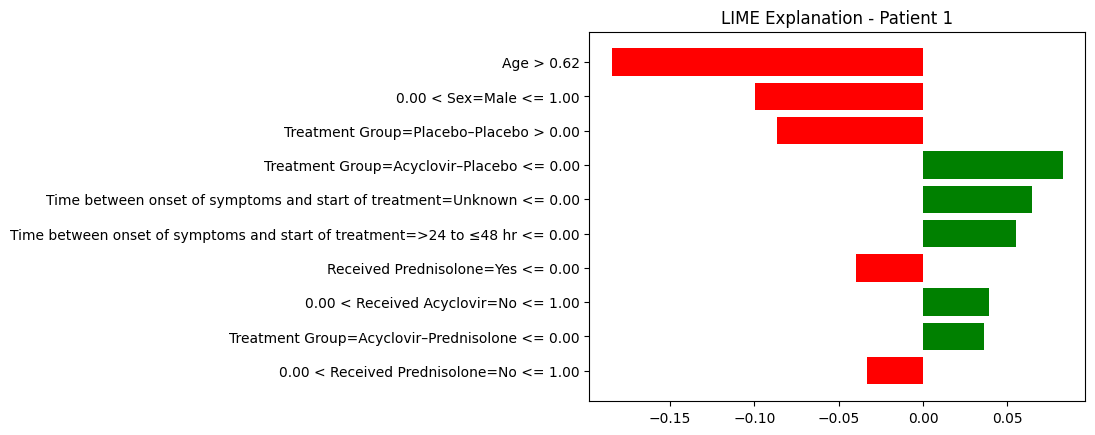

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ LIME explanation for patient 2:


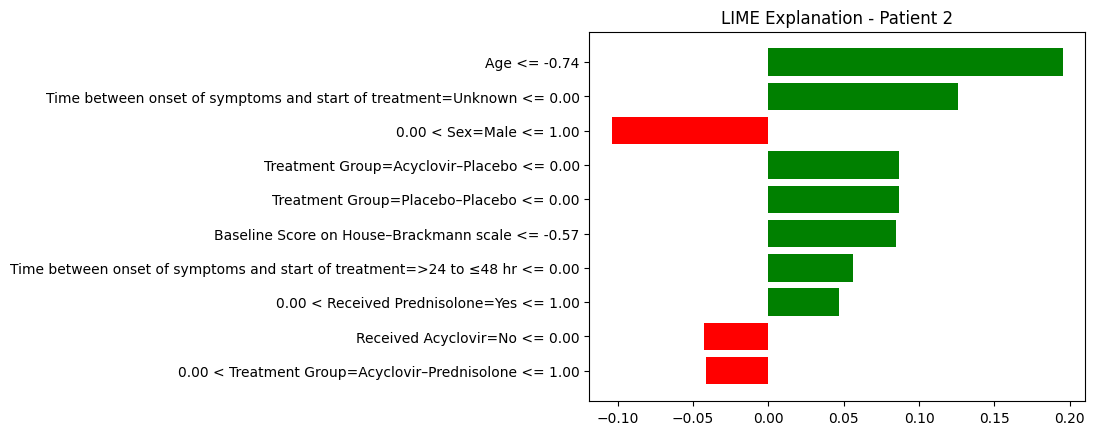


💾 CNN model saved as bells_palsy_cnn_model_with_LIME_fixed.h5


In [4]:
# ✅ Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn joblib tensorflow lime --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization

from lime.lime_tabular import LimeTabularExplainer


# 1. Load Dataset
df = pd.read_csv("Bells Palsy Clinical Trial.csv")

# Target column
target_col = "Full Recovery in 3 Months"
y = df[target_col].map({"Yes": 1, "No": 0})

# Features
features = [
    'Sex',
    'Age',
    'Baseline Score on House–Brackmann scale',
    'Time between onset of symptoms and start of treatment',
    'Treatment Group',
    'Received Prednisolone',
    'Received Acyclovir',
]
X = df[features].copy()


# 2. Preprocessing (numerical + categorical)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply preprocessing
X_train_transformed = preprocess.fit_transform(X_train)
X_test_transformed = preprocess.transform(X_test)

# Convert to numpy arrays
X_train_transformed = np.array(X_train_transformed.todense()) if hasattr(X_train_transformed, "todense") else np.array(X_train_transformed)
X_test_transformed = np.array(X_test_transformed.todense()) if hasattr(X_test_transformed, "todense") else np.array(X_test_transformed)

# Reshape for CNN (samples, features, 1)
X_train_cnn = X_train_transformed.reshape(X_train_transformed.shape[0], X_train_transformed.shape[1], 1)
X_test_cnn = X_test_transformed.reshape(X_test_transformed.shape[0], X_test_transformed.shape[1], 1)


# 4. CNN Model
model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=2, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(1, activation="sigmoid")  # Binary classification
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# 5. Train Model
history = model.fit(X_train_cnn, y_train, epochs=30, batch_size=16,
                    validation_data=(X_test_cnn, y_test), verbose=1)

# 6. Evaluate
loss, acc, auc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc:.3f}")
print(f"✅ Test AUC: {auc:.3f}")

# 7. Classification Report
y_pred_prob = model.predict(X_test_cnn).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Recovery","Recovery"],
            yticklabels=["No Recovery","Recovery"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve - CNN")
plt.show()


# 8. LIME Explainability
print("\n🔎 Running LIME explainability on CNN...")

# Get feature names after preprocessing
def get_feature_names(preprocess, numeric_cols, categorical_cols):
    feat_names = numeric_cols.copy()
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    for col, cats in zip(categorical_cols, ohe.categories_):
        feat_names.extend([f"{col}={cat}" for cat in cats])
    return feat_names

feat_names = get_feature_names(preprocess, numeric_cols, categorical_cols)

# Initialize LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_transformed),
    feature_names=feat_names,
    class_names=["No Recovery", "Recovery"],
    mode="classification"
)

# ✅ Fix: CNN predict_fn must return two columns [P(No), P(Yes)]
def predict_fn(x):
    preds = model.predict(x.reshape(x.shape[0], x.shape[1], 1))
    return np.hstack([1 - preds, preds])  # shape = (n_samples, 2)

# Explain first 3 patients
for sample_idx in range(3):
    exp = explainer.explain_instance(
        data_row=X_test_transformed[sample_idx],
        predict_fn=predict_fn
    )

    print(f"\n✅ LIME explanation for patient {sample_idx}:")
    exp.show_in_notebook(show_table=True)
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Patient {sample_idx}")
    plt.show()


# 9. Save CNN Model
model.save("bells_palsy_cnn_model_with_LIME_fixed.h5")
print("\n💾 CNN model saved as bells_palsy_cnn_model_with_LIME_fixed.h5")
